In [1]:
import nltk; nltk.download('stopwords')
! pip install pyLDAvis

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import bs4 as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os as matplotlib
import requests as requests
import csv



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.7MB 4.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135593 sha256=6f666d718e229ab11324c632acfbc22a3b3a68e99cd8547016aeb3dd4e16b720
  Stored in directory: /root/.cache/pip/wheels/74/df/b6/97234c8446a43be05c9a8687ee0db1f1b5ade5f27729187eae
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [2]:
from google.colab import auth
auth.authenticate_user()
project_id = 'hashi-nlp'
!gcloud config set project {project_id}
bucket_name = 'roseglavinhashi'

TASK = 'LanguageModel' #@param {type:"string"}

TASK_DATA_DIR =  TASK
print('***** Task data directory: {} *****'.format(TASK_DATA_DIR))
!mkdir -p $TASK_DATA_DIR
!ls $TASK_DATA_DIR

BUCKET = 'roseglavinhashi' #@param {type:"string"}

OUTPUT_DIR = 'gs://{}/models/{}'.format(BUCKET, TASK)
!mkdir -p  OUTPUT_DIR 
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
!gsutil -m cp -r gs://roseglavinhashi/mallet-2.0.8.zip . 



Updated property [core/project].
***** Task data directory: LanguageModel *****
***** Model output directory: gs://roseglavinhashi/models/LanguageModel *****
Copying gs://roseglavinhashi/mallet-2.0.8.zip...
/ [1/1 files][ 15.4 MiB/ 15.4 MiB] 100% Done                                    
Operation completed over 1 objects/15.4 MiB.                                     
CommandException: Wrong number of arguments for "cp" command.


In [3]:
!gsutil -m cp -r gs://roseglavinhashi/PFtext.csv .

Copying gs://roseglavinhashi/PFtext.csv...
/ [1/1 files][804.3 KiB/804.3 KiB] 100% Done                                    
Operation completed over 1 objects/804.3 KiB.                                    


In [4]:
 !unzip mallet-2.0.8.zip


Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classify  
  inflating: mallet-2.0.8/bin/text2vectors  
  inflating: mallet-2.0.8/bin/vectors2classify  
  inflating: mallet-2.0.8/bin/vectors2info  
  inflating: mallet-2.0.8/bin/vectors2topics  
  inflating: mallet-2.0.8/bin/vectors2vectors  
  inflating: mallet-2.0.8/build.xml  
   creating: mallet-2.0.8/class/
   creating: mallet-2.0.8/class/cc/
   creating: mallet-2.0.8/class/cc/mallet/
   creating: mallet-2.0.8/class/cc/mallet/classify/
  inflating: mallet-2.0.8/class/cc/mallet/classify/AdaBoost.class  
  in

Prepare Stop Words


In [24]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'unspecified','of','type' ,'region','site','disease'])

In [25]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

GET DATA INTO DATEFRAME 


In [26]:
df = pd.read_csv('PFtext.csv')
df.head(50)

,Unnamed: 0,MedicalText
0,1,Routine general medical examination at a healt...
1,2,"Urinary tract infection, site not specified"
2,3,Plantar wart
3,4,Syncope and collapse
4,5,Pain in joint involving lower leg
5,6,"Peptic ulcer, site unspecified ..."
6,7,Corn/callus
7,8,"Anxiety state, unspecified"
8,9,Multiple sclerosis
9,10,"Osteoarthrosis, unspecified whether generalize..."


CLEAN UP TEXT 

In [28]:
# Convert to list
data = df.MedicalText.values.tolist()

# Remove Emails
#data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
#data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
#data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Routine general medical examination at a health care facility']


PREPROCESS DATA


In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['routine', 'general', 'medical', 'examination', 'at', 'health', 'care', 'facility']]


BUILD xGRAMS

NOTE: We know these will be boing in this case because we are using standard repeating text. But the words are still interesting. 
And if we could do the same thing with free text we might get interesting constellations that fall outside of what we expect medically. 

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['routine', 'general', 'medical', 'examination', 'at', 'health', 'care', 'facility']


In [35]:
data_words

[['routine',
  'general',
  'medical',
  'examination',
  'at',
  'health',
  'care',
  'facility'],
 ['urinary', 'tract', 'infection', 'site', 'not', 'specified'],
 ['plantar', 'wart'],
 ['syncope', 'and', 'collapse'],
 ['pain', 'in', 'joint', 'involving', 'lower', 'leg'],
 ['peptic', 'ulcer', 'site', 'unspecified'],
 ['corn', 'callus'],
 ['anxiety', 'state', 'unspecified'],
 ['multiple', 'sclerosis'],
 ['osteoarthrosis',
  'unspecified',
  'whether',
  'generalized',
  'or',
  'localized',
  'involving',
  'unspecified',
  'site'],
 ['pain', 'in', 'limb'],
 ['chronic', 'pain', 'syndrome'],
 ['unspecified', 'sleep', 'disturbance'],
 ['other', 'and', 'unspecified', 'hyperlipidemia'],
 ['chronic', 'hepatitis', 'with', 'hepatic', 'coma'],
 ['depressive', 'disorder', 'not', 'elsewhere', 'classified'],
 ['unspecified', 'hypothyroidism'],
 ['unspecified', 'chronic', 'disease', 'of', 'tonsils', 'and', 'adenoids'],
 ['microscopic', 'hematuria'],
 ['sprain', 'of', 'other', 'specified', 'sites'

In [31]:
print(trigram_mod[bigram_mod[data_words[1]]])

['urinary', 'tract', 'infection', 'site', 'not', 'specified']


In [32]:
print(trigram_mod[bigram_mod[data_words[2]]])

['plantar', 'wart']


In [33]:
print(trigram_mod[bigram_mod[data_words[3]]])

['syncope', 'and', 'collapse']


REMOVE STOP WORDS , LEMMATIZE 

In [36]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [38]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['routine', 'care', 'facility']]


Create the Dictionary and Corpus needed for Topic Modeling

In [39]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [40]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]


[[('care', 1), ('facility', 1), ('routine', 1)]]

BUILD THE TOPIC MODEL

In [59]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

View the topics in LDA model

In [61]:
# Print the Keyword in the 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.072*"pain" + 0.053*"involve" + 0.032*"allergic" + 0.032*"joint" + '
  '0.027*"osteoarthrosis" + 0.024*"low" + 0.023*"coronary" + 0.023*"leg" + '
  '0.022*"rhinitis" + 0.018*"abnormal"'),
 (1,
  '0.106*"acute" + 0.087*"hypertension" + 0.079*"essential" + 0.036*"chronic" '
  '+ 0.033*"benign" + 0.029*"sinusitis" + 0.027*"bronchitis" + 0.024*"heart" + '
  '0.022*"upper" + 0.019*"abdominal"'),
 (2,
  '0.059*"disorder" + 0.046*"mixed" + 0.046*"specify" + 0.036*"mention" + '
  '0.029*"urinary" + 0.028*"deficiency" + 0.026*"infection" + 0.025*"tract" + '
  '0.020*"depressive" + 0.019*"routine"')]


Compute Perplexity and Coherence

In [62]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.533467012564687

Coherence Score:  0.664123164013915


Visualize Topic Keywords 

In [63]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.026919 -0.350594       1        1  35.926905
0     -0.325385  0.152605       2        1  32.311120
1      0.298465  0.197989       3        1  31.761975, topic_info=             Term        Freq       Total Category  logprob  loglift
47          acute  787.000000  787.000000  Default  30.0000  30.0000
63   hypertension  644.000000  644.000000  Default  29.0000  29.0000
62      essential  589.000000  589.000000  Default  28.0000  28.0000
13           pain  545.000000  545.000000  Default  27.0000  27.0000
28       disorder  496.000000  496.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
21           limb   65.360823   66.125110   Topic3  -4.7348   1.1353
480         stage   53.842738   54.489489   Topic3  -4.9287   1.1350
338        senile   51.306164   51.950885   Topic3  -4.9769   1.1344
116  hypertensive   50.826195   51.472449   Topic3  -4.9863   1.1343
3       infection   99.041857  316.012543   Topic3  -4.3192  -0.0133

[125 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
34        3  0.993283    abdominal
64        2  0.992492     abnormal
200       2  0.994457      acquire
47        3  0.999332        acute
49        2  0.997742     allergic
...     ...       ...          ...
171       3  0.994124        upper
6         1  0.998572      urinary
78        1  0.991374          use
168       3  0.993140  vaccination
66        2  0.983607       weight

[98 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

Building LDA Mallet Model

In [53]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

mallet_path = './mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=15, id2word=id2word)

In [54]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(1,
  [('hypertension', 0.39950980392156865),
   ('essential', 0.37193627450980393),
   ('benign', 0.1721813725490196),
   ('blood', 0.003676470588235294),
   ('ally', 0.003676470588235294),
   ('cyst', 0.003676470588235294),
   ('nontraumatic', 0.0024509803921568627),
   ('pylori', 0.001838235294117647),
   ('femur', 0.001838235294117647),
   ('ingrowe', 0.001838235294117647)]),
 (4,
  [('pure', 0.09163879598662207),
   ('coronary', 0.0822742474916388),
   ('state', 0.06555183946488294),
   ('atherosclerosis', 0.06086956521739131),
   ('otitis', 0.05953177257525084),
   ('medium', 0.046822742474916385),
   ('symptomatic', 0.044816053511705686),
   ('artery', 0.04013377926421405),
   ('climacteric', 0.03879598662207358),
   ('menopausal', 0.03879598662207358)]),
 (9,
  [('abnormal', 0.11195445920303605),
   ('nonspecific', 0.0683111954459203),
   ('skin', 0.06641366223908918),
   ('malignant', 0.05945604048070841),
   ('loss', 0.0480708412397217),
   ('weight', 0.04364326375711575),
 

NOTE: Agian we know that coherence is a strange meaning in this context. We have including a bunch of canned text, that will have some overlap between sentences but for the most part coherence is not meaningful. BUT if we do this same exercise with free text we should get more meaningful results. 

find the optimal number of topics for LDA?

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [51]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

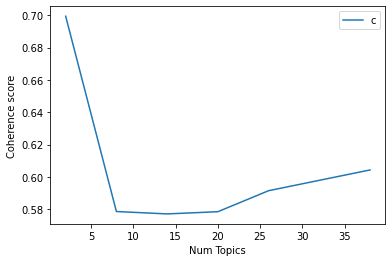

In [52]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()